In [1]:
# Capítulo 4 do livro Hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow
# Códigos disponíveis em https://github.com/ageron/handson-ml2/blob/master/04_training_linear_models.ipynb
# Este notebook é somente o acompanhamento do capítulo com alguns comentários de Enzo Albuquerque :)

# Configurações

In [2]:
# Verificando as versões do Python e Scikit-Learn

# Python >= 3.5 é requerido
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn >= 0.20 é requerido
import sklearn
assert sklearn.__version__ >= "0.20"

# Importações comuns
import numpy as np
import os

# Para gerar figuras bonitas
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Onde salvar as figuras
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

# Definindo função para salvar as figuras
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignorar avisos sem utilidade (veja SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="înternal gelsd")

# Regressão linear usando a equação normal

In [3]:
# Para analisar o modelo de regressão linear obtido com a equação normal, primeiro vamos gerar um banco de dados linear 
# com ruído
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

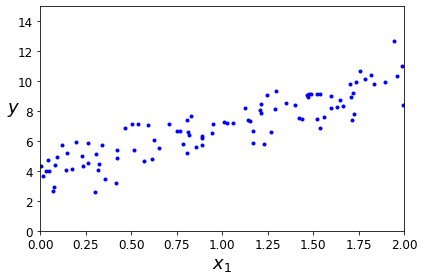

In [4]:
# Olhando em um gráfico como estão os dados
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("generated_data_plot")
plt.show()

In [5]:
# Agora vamos adicionar o viés (bias) aos nossos dados de previsão (simplesmente adicionar na primeira coluna zeros)
# e calcular os parâmetros theta a partir da equação normal (a que fornece o resultado exato da melhor reta)
X_b = np.c_[np.ones((100, 1)), X] # adicionando x0 = 1 para cada instância
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [6]:
# Vamos ver qual foram os valores dos parâmetros (este valor sempre vai ser diferente do livro, por causa do ruído aleatório)
theta_best

array([[3.90235575],
       [3.10409924]])

In [7]:
# Vamos ver as previsões agora
X_new = np.array([[0], [2]]) # criando os dados de atributos para previsão
X_new_b = np.c_[np.ones((2, 1)), X_new] # adicionando aos dados de atributo o viés
y_predict = X_new_b.dot(theta_best) # calculando a previsão com o theta encontrado
y_predict

array([[ 3.90235575],
       [10.11055424]])

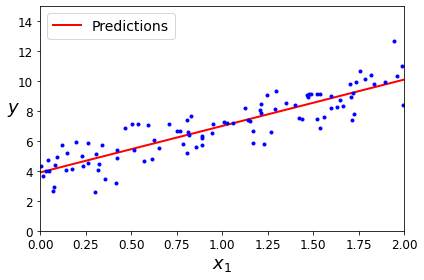

In [8]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
save_fig("linear_model_predictions_plot")
plt.show()

In [9]:
# O scikit-learn possui uma função para realizar este procedimento de cálculo da regressão linear
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([3.90235575]), array([[3.10409924]]))

In [10]:
lin_reg.predict(X_new)

array([[ 3.90235575],
       [10.11055424]])

In [11]:
# A vantagem de usar esta função do scikit-learn é que ela é baseada na classe scipy.linalg.lstsq(), e esta calcula
# o pseudoinverso da matriz, logo, sempre fornece um resultado, pois sempre existirá um pseudoinverso.
# Em contraposição, a inversa exata só existe em condições específicas
# Para utilizar diretamente esta classe do scipy basta
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[3.90235575],
       [3.10409924]])

In [12]:
# Pseudoinverso
np.linalg.pinv(X_b).dot(y)

array([[3.90235575],
       [3.10409924]])

## Regressão linear usando batch gradient descent

In [13]:
eta = 0.1 # taxa de aprendizado
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) # inicialização aleatória

# Montanto a iteração que realiza o batch gradient descent
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [14]:
theta

array([[3.90235575],
       [3.10409924]])

In [15]:
X_new_b.dot(theta)

array([[ 3.90235575],
       [10.11055424]])

In [16]:
# Agora vamos criar uma função para ilustrar como ocorre o treinamento para diferentes valores de taxa de aprendizado
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

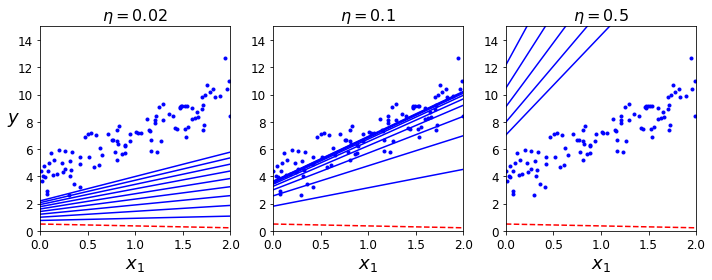

In [17]:
# Agora vamos colocar para gerar os gráfico para os diferentes balores de taxa de aprendizado
# Perceba como a taxa de aprendizado influencia no treinamento. Para eta baixo este vai em direção ao ajuste correto, no 
# entanto demora, já com um eta muito grande ele não consegue estabilizar nos valores ótimos.
np.random.seed(42)
theta = np.random.randn(2,1) # inicialização aleatória

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

## Stochastic Gradient Descent

In [18]:
# Vamos testar agora o gradient descent aleatório, o qual a função custo de uma instância aleatória.
# Para este funcionar melhor é necessário ir diminuindo a taxa de aprendizado, para não fugir sempre do mínimo local
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

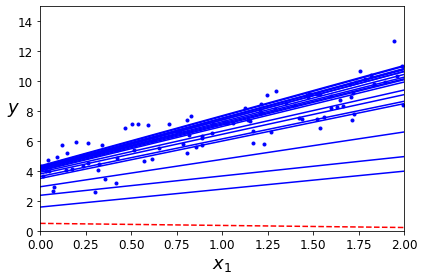

In [19]:
n_epochs = 50
t0, t1 = 5, 50 # hyperparâmetro do cronograma de aprendizagem

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # inicialização aleatória

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)  # definindo um índice aleatório
        xi = X_b[random_index:random_index+1] # selecionando um x correspondente ao índice
        yi = y[random_index:random_index+1] # selecionando um y correspondente ao índice
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i) # variando a taxa de aprendizado
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)
        
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("sgd_plot")
plt.show()

In [20]:
theta

array([[3.89898676],
       [3.08100945]])

In [21]:
# O scikit-learn possui a classe `SGDRegressor` que treina um modelo linear com o stochastic gradient descent
from sklearn.linear_model import SGDRegressor

# Será utilizado um SGD sem cronograma de aprendizagem, com eta constante, e sem regularização
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.88640707]), array([3.16845034]))

## Mini-batch gradient descent

In [23]:
# O intermediário entre o batch gradient descent e o stochastic gradient descent é o mini-batch gradient descent
# o qual não faz o treinamento baseado em todas as amostras, mas também não utiliza somente uma amostra
# este pega um conjunto aleatório para avaliar
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1) # inicialização aleatória

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m) # fazendo a permutação dos índices
    X_b_shuffled = X_b[shuffled_indices] # permutando os dados em x
    y_shuffled = y[shuffled_indices] # permutando os dados em y, com os mesmos índices utilizados em x
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [24]:
theta

array([[3.92122387],
       [3.10543641]])

In [25]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

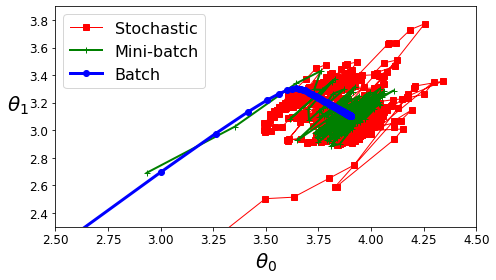

In [26]:
# Vamos agora criar um gráfico comparativo entre as formas de aprendizado analisadas
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

## Regressão polinomial

In [27]:
# Quando o problema não é linear, uma forma simples de construir um modelo não linear é adicionar atributos polinômias
# a partir dos atributos prévios. Com isto, é possível utilizar o mesmo algoritmo de otimização e fornecer ajustes
# não lineares
import numpy as np
import numpy.random as rnd

rnd.seed(42)

In [28]:
# Vamos criar um banco de dados não linear a partir de um função quadrática com ruído
m = 100
X = 6 * rnd.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + rnd.randn(m, 1)

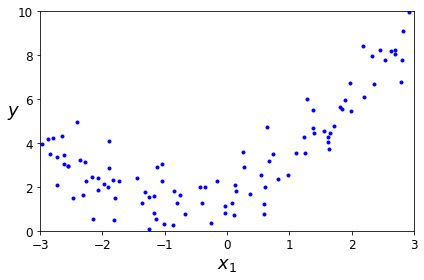

In [29]:
# Vamos visualizar este banco de dados
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

In [30]:
# O scikit-learn possui a classe `PolynomialFeatures` que transforma os dados de treino adicionando novos atributos
# polinomiais a partir de cada atributo prévio
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.75275929])

In [31]:
# Perceba que o segundo termo é o quadrado do primeiro
X_poly[0]

array([-0.75275929,  0.56664654])

In [32]:
# Agora que já temos os atributos com polinômios, podemos aplicar o mesmo algoritmo de regressão linear para ajustar
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

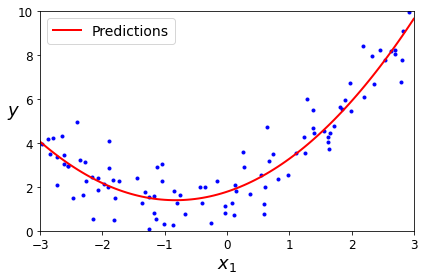

In [33]:
# Vamos visualizar este ajuste
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

## Curvas de aprendizagem

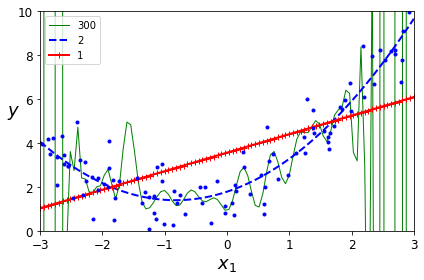

In [34]:
# Vamos comparar o que acontece quando utilizamos muitos graus de polinômios com o modelo linear e de 2 graus 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ("poly_features", polybig_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)
    
plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polyomial_plot")
plt.show()

In [35]:
# Para verificar se um modelo está super ajustando como o polinômio de 300 graus acima ou sub ajustando como a reta,
# nós podemos verificar utilizando a validação cruzada ou gerar uma curva de aprendizagem
# Vamos verificar como construi-la
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

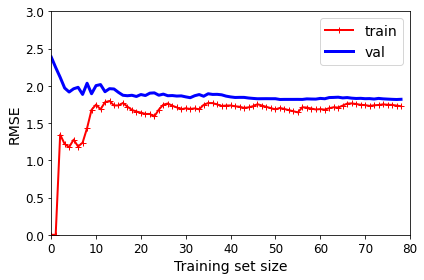

In [36]:
# Analisando a curva de aprendizagem para o caso linear, de sub ajuste
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig("underfitting_learning_curves_plot")
plt.show()

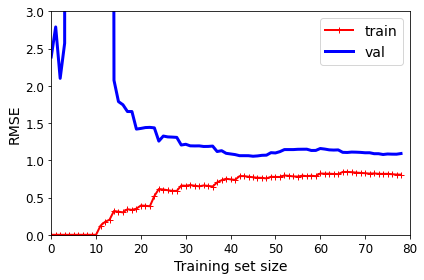

In [37]:
# Analisando a curva de aprendizagem para polinômio de 10 graus, caso de super ajuste
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
    ("lin_reg", LinearRegression()),
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
save_fig("learning_curves_plot")
plt.show()

## Modelos regularizados

In [38]:
# Vamos primeiro criar um banco de dados
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

### Ridge Regression

In [39]:
# Vamos utilizar o `ridge regression` para fazer uma regressão linear com o `solver` cholesky, o termo alpha determinar
# o quanto será regularizado o modelo, quanto maior mais regularizado este será.
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [40]:
# Vamos variar o `solver` para o sag e verificar a diferença do resultado para 1.5
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.5507201]])

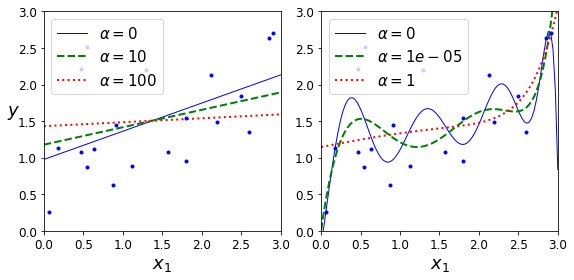

In [41]:
# Agora vamos criar um gráfico para visualizar o que acontece quando variamos o valor de alpha
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                ("std_scaler", StandardScaler()),
                ("regul_reg", model),
            ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0 ,3])
    
plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

In [42]:
# Caso deseja-se utilizar o método de treinamento stochastic gradient descent com regularização basta
# adicionar a `penalty` l2
sgd_reg = SGDRegressor(penalty="l2", max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.47012588])

### Lasso Regression

C:\Users\enzoa\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.802867703827432, tolerance: 0.0009294783355207351
  model = cd_fast.enet_coordinate_descent(


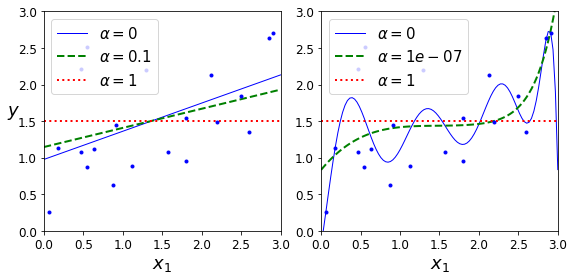

In [43]:
# Vamos testar outro agloritmo de regularização o lasso regression, ele implementa a regularização l1
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

In [44]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

### Elastic Net

In [45]:
# Outra forma de regularização é o elastic net, o qual é um intermediário entre o ridge e o lasso regression
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### Early Stopping

In [46]:
# Vamos criar o banco de dados e separá-los entre treino e validação
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [47]:
# O early stopping serve para parar o treinamento no valor mínimo do erro da validação cruzada, evitando que após passar
# pelo mínimo o modelo comece o superajuste
from copy import deepcopy

poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
    ("std_scaler", StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) # Com warm_start=True, o treino continua de onde parou
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

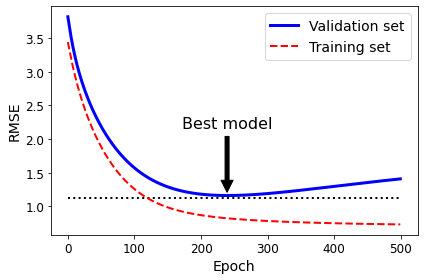

In [48]:
# Vamos criar um gráfico para entender melhor o que está acontecendo
sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)
n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
    
best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03 # apenas para o tracejado ficar um pouco abaixo e a visualização ser melhor
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")
plt.show()

In [49]:
best_epoch, best_model

(239,
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=-inf, warm_start=True))

---

In [50]:
# Vamos criar um gráfico para entender melhor como funciona a regularização com a norma l1 e a l2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [51]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

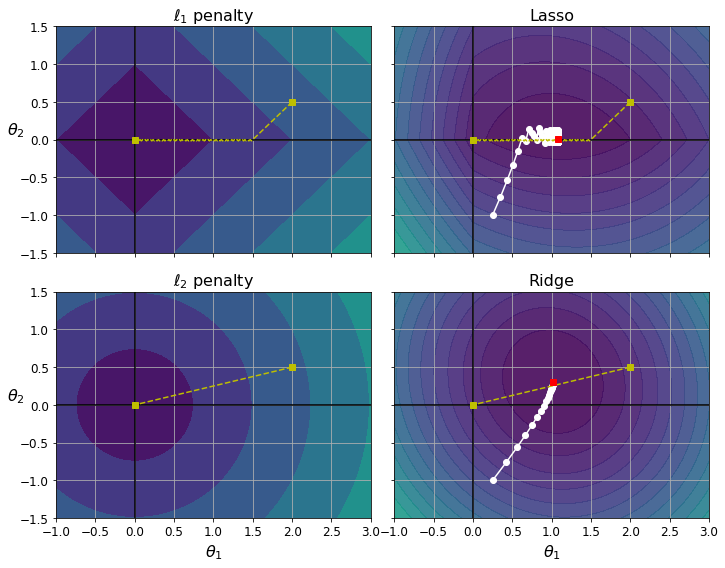

In [52]:
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0, 2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2
    
    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]
    
    levelsJ=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(J) - np.min(J)) + np.min(J)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)
    levelsN=np.linspace(0, np.max(N), 10)
    
    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)
    
    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, N / 2., levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)
    
    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
        
save_fig("lasso_vs_ridge_plot")
plt.show()

## Regressão logística

### Fronteira de decisão

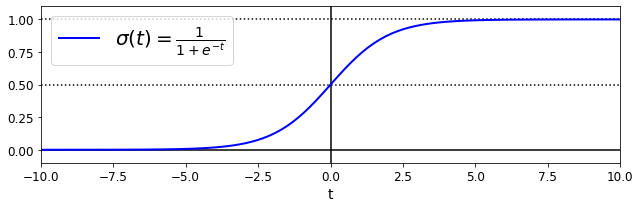

In [54]:
# A regressão logistica é dada pelo somatório dos atributos com pesos aplicado à função logísticas
# a função logística é a seguinte
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

In [56]:
# Vamos testar a regressão logística nos dados das flores iris
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [57]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [58]:
# Vamos aplicar o modelo só sobre o atributo da largura das pétalas e analisá-lo
X = iris["data"][:, 3:] # largura da pétala
y = (iris["target"] == 2).astype(np.int) # 1 se iris viginica, ao contrário 0

In [60]:
# Vamos ajustar agora os dados à regressão logística
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

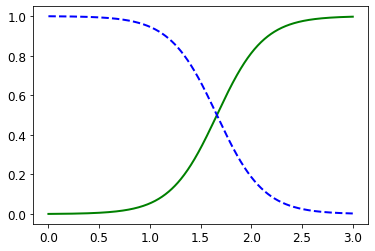

In [61]:
# Vamos visualizar como está a função de decisão para a classe iris virginica e not iris virginica
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

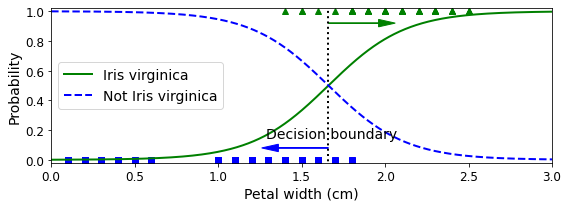

In [63]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

In [64]:
# A fronteira de previsão é a seguinte
decision_boundary

array([1.66066066])

In [65]:
# Vamos verificar a previsão
log_reg.predict([[1.7], [1.5]])

array([1, 0])

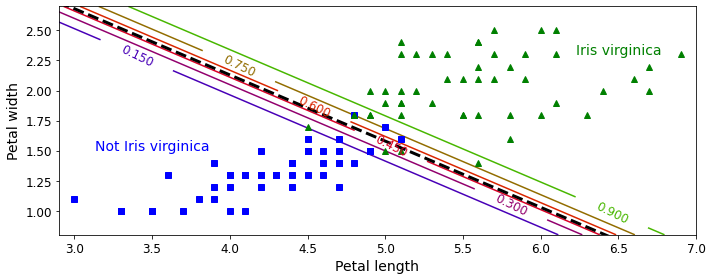

In [68]:
# Vamos verificar agora como se comporta a fronteira de decisão quando utilizamos 2 atributos
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)] # comprimento da pétala, largura da pétala
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver = "lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

### Regressão softmax

In [70]:
# Vamos verificar a regressão softmax, a qual é uma generalização da regressão logística para multiplas classses
# também é conhecida como multinomial, nome inserido na parâmetro `multi_class` da `LogisticRegression`
X = iris["data"][:, (2, 3)] # comprimento da pétala, largura da pétala
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

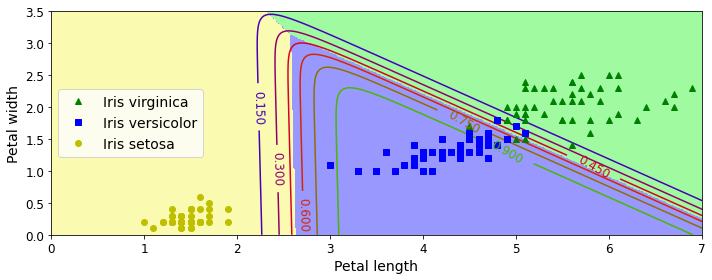

In [71]:
# Vamos criar agora um gráfico para visualizar as fronteiras de decisões
x0, x1 = np.meshgrid(
    np.linspace(0, 8, 500).reshape(-1, 1),
    np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

In [72]:
# Previsão para uma pétala com comprimento 5 e largura 2
softmax_reg.predict([[5, 2]])

array([2])

In [73]:
# Probabilidades da previsão
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])